

## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Установка зависимостей

In [1]:
# ВНИМАНИЕ; версия Pillow установвленна по умолчанию - '7.0.0'
# Эта версия ломает torchvision
import PIL
PIL.__version__

'9.0.1'

**Обучая сеть на Kaggle я обнаружил, что с PIL.__version__=='9.0.1' всё работает отлично, поэтому здесь я не переустанавливал пакеты**

In [1]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
!nvidia-smi
torch.cuda.is_available()

Sun Apr 17 12:45:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    29W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [4]:
import pickle
import numpy as np
import pandas as pd

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import models

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [5]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} \\$,      константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [55]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = {
            'train': transforms.Compose([
                transforms.ToTensor(),
                
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(degrees=15),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'val': transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'test': transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        }
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform[self.mode](x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        # наставляет паддинг, чтобы не изменялись пропорции изображения
        w, h = image.size
        max_wh = np.max([w, h])
        hp = int((max_wh - w) / 2)
        vp = int((max_wh - h) / 2)
        padding = (hp, vp, hp, vp)

        image = transforms.functional.pad(image, padding, 0, 'constant')
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [7]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [13]:
TRAIN_DIR = Path('../input/simpsons/train/simpsons_dataset')
TEST_DIR = Path('../input/simpsons/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

### Изучим распределение классов

In [14]:
from sklearn.model_selection import train_test_split
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [15]:
train_labels = [path.parent.name for path in train_files]
val_labels = [path.parent.name for path in val_files]                                         

In [16]:
print(pd.Series(train_val_labels).value_counts())

homer_simpson               2246
ned_flanders                1454
moe_szyslak                 1452
lisa_simpson                1354
bart_simpson                1342
marge_simpson               1291
krusty_the_clown            1206
principal_skinner           1194
charles_montgomery_burns    1193
milhouse_van_houten         1079
chief_wiggum                 986
abraham_grampa_simpson       913
sideshow_bob                 877
apu_nahasapeemapetilon       623
kent_brockman                498
comic_book_guy               469
edna_krabappel               457
nelson_muntz                 358
lenny_leonard                310
mayor_quimby                 246
waylon_smithers              181
maggie_simpson               128
groundskeeper_willie         121
barney_gumble                106
selma_bouvier                103
carl_carlson                  98
ralph_wiggum                  89
patty_bouvier                 72
martin_prince                 71
professor_john_frink          65
snake_jail

**Видим, что классы несбалансированные. Нужно сделать oversampling с последующими аугментациями**

In [17]:
def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

def print_dct(dct_simpsons):
    for key in dct_simpsons:
        print(f"{key}\n{dct_simpsons[key]}")

In [18]:
dct_path_train = create_dct_path_labels(train_files, train_labels)

**Если число объектов в классе, меньше 200, то продублируем эти элеметы, чтобы их стало 200**

In [19]:
for person in dct_path_train.keys():
    if len(dct_path_train[person]) < 200:
        dct_path_train[person] = dct_path_train[person] * (200 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:200 - len(dct_path_train[person])])

In [20]:
new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

new_train_label = [path.parent.name for path in new_train_files]

In [21]:
print(pd.Series(new_train_label).value_counts())

homer_simpson               1684
ned_flanders                1090
moe_szyslak                 1089
lisa_simpson                1015
bart_simpson                1006
marge_simpson                968
krusty_the_clown             904
principal_skinner            895
charles_montgomery_burns     895
milhouse_van_houten          809
chief_wiggum                 739
abraham_grampa_simpson       685
sideshow_bob                 658
apu_nahasapeemapetilon       467
kent_brockman                373
comic_book_guy               352
edna_krabappel               343
nelson_muntz                 269
lenny_leonard                233
selma_bouvier                200
ralph_wiggum                 200
professor_john_frink         200
sideshow_mel                 200
snake_jailbird               200
troy_mcclure                 200
patty_bouvier                200
otto_mann                    200
rainier_wolfcastle           200
maggie_simpson               200
miss_hoover                  200
mayor_quim

In [22]:
train_dataset = SimpsonsDataset(new_train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')

**Давайте посмотрим на наших героев внутри датасета.**

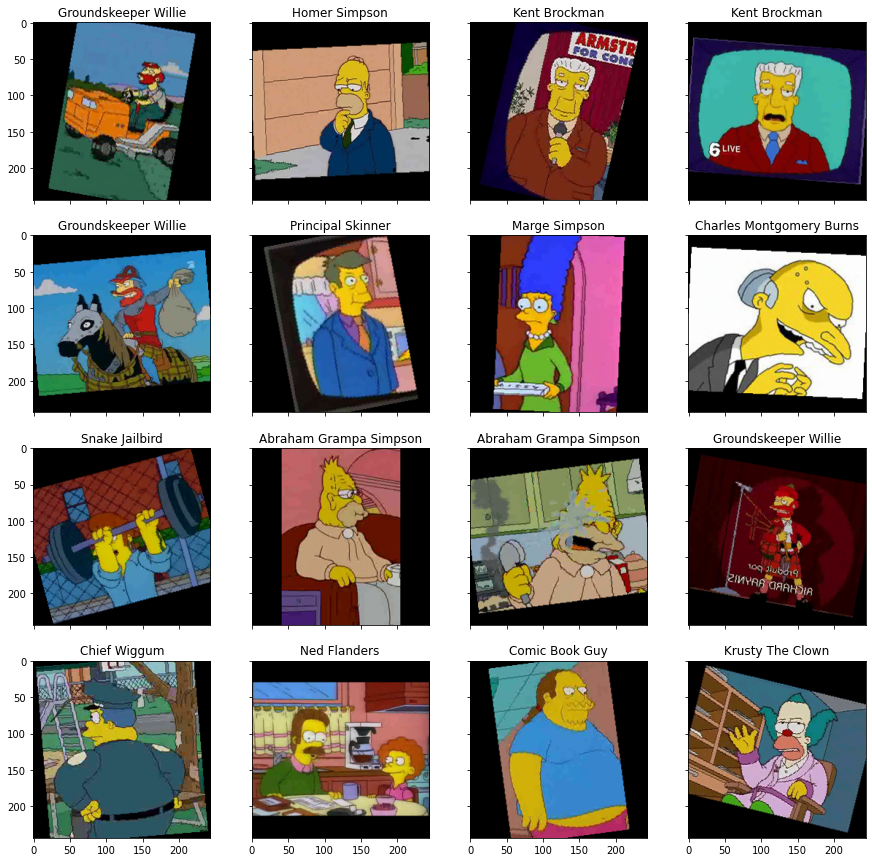

In [54]:
fig, ax = plt.subplots(nrows=4, ncols=4,figsize=(15, 15), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = np.random.randint(0,len(new_train_label))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [66]:
#Without batchnorm
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [67]:
# BatchNorm befor activation
class SimpleCnnBNbefore(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(num_features=8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(num_features=96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [43]:
def fit_epoch(model, train_loader, criterion, optimizer, lr_sched):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    if lr_sched is not None:
        lr_sched.step()

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [44]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = float((running_corrects.double() / processed_size).cpu().numpy())
    return val_loss, val_acc

In [45]:
def train(train_files, val_files, model, epochs, batch_size, opt, lr_sched=None):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    max_val_acc = 0
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, lr_sched)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            #save the best weights
            if val_acc > max_val_acc:
                max_val_acc = val_acc
                torch.save(model.state_dict(), "MyBestModel.pth")
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [46]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [68]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

In [47]:
# Функция для расчета accuracy для каждого класса
def make_accuracy(model):
    imgs = [val_dataset[id][0].unsqueeze(0) for id in range(len(val_dataset))]
    probs_ims = predict(model, imgs)
    
    y_pred = label_encoder.inverse_transform(np.argmax(probs_ims, axis=1))
    y_true = label_encoder.inverse_transform(np.array([val_dataset[id][1] for id in range(len(val_dataset))]))

    total_sums = {}
    accuracies = {}
    
    for label in y_true:
        if label not in total_sums.keys():
            total_sums[label] = 1
        else:
            total_sums[label] += 1

    for i in range(len(y_true)):
        label = y_true[i]
        if label not in accuracies.keys():
            if y_pred[i] == y_true[i]:
                accuracies[label] = 1
            else:
                accuracies[label] = 0
        else:
            if y_pred[i] == y_true[i]:
                accuracies[label] += 1

    for label in accuracies.keys():
        accuracies[label] /= total_sums[label]

    acc = pd.DataFrame.from_dict(data = accuracies, orient='index',columns=['val_acc'])
    total_train = pd.DataFrame(data = pd.Series(new_train_label).value_counts(), columns=['total in train set'])
    total_val = pd.DataFrame(data = pd.Series(val_labels).value_counts(), columns=['total in val set'])
    acc_sort = acc.join(total_train).join(total_val).sort_values(by=['val_acc'])

    return acc_sort

In [80]:
#Функция для расчета f1-score для n объектов валидационного датасета

from sklearn.metrics import f1_score
def make_f1_score(model, n=1000):

    idxs = list(map(int, np.random.uniform(0, n, n)))

    imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

    probs_ims = predict(model, imgs)

    y_pred = np.argmax(probs_ims,-1)

    actual_labels = [val_dataset[id][1] for id in idxs]

    preds_class = list(y_pred)

    return f1_score(actual_labels, preds_class, average='micro')


In [78]:
def plot_loss(loss, val_loss):
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

In [79]:
def plot_acc(acc, val_acc):
    plt.figure(figsize=(15, 9))
    plt.plot(acc, label="train_acc")
    plt.plot(val_acc, label="val_acc")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("acc")
    plt.grid()
    plt.show()

Запустим обучение сети.

**Adam**

In [81]:
model1 = SimpleCnn(n_classes).to(DEVICE)
history_adam = train(train_dataset, val_dataset, model=model1, epochs=3, batch_size=64, opt=torch.optim.Adam(model1.parameters()))

epoch:   0%|          | 0/3 [00:00<?, ?it/s]

loss 2.706139997352503


epoch:  33%|███▎      | 1/3 [04:43<09:26, 283.06s/it]


Epoch 001 train_loss: 2.7061     val_loss 1.8605 train_acc 0.2846 val_acc 0.5017
loss 1.4604427235499235


epoch:  67%|██████▋   | 2/3 [08:58<04:26, 266.85s/it]


Epoch 002 train_loss: 1.4604     val_loss 1.2816 train_acc 0.6075 val_acc 0.6695
loss 0.9879054622454152


epoch: 100%|██████████| 3/3 [13:15<00:00, 265.11s/it]


Epoch 003 train_loss: 0.9879     val_loss 1.0899 train_acc 0.7285 val_acc 0.7155


**Adam with BatchNorm before activation**

In [82]:
model2 = SimpleCnnBNbefore(n_classes).to(DEVICE)
history_adam_bn = train(train_dataset, val_dataset, model=model2, epochs=3, batch_size=64, opt=torch.optim.Adam(model2.parameters()))

epoch:   0%|          | 0/3 [00:00<?, ?it/s]

loss 1.8661533182642551


epoch:  33%|███▎      | 1/3 [04:19<08:39, 259.84s/it]


Epoch 001 train_loss: 1.8662     val_loss 1.4658 train_acc 0.5066 val_acc 0.6078
loss 1.01514463233844


epoch:  67%|██████▋   | 2/3 [08:39<04:19, 259.83s/it]


Epoch 002 train_loss: 1.0151     val_loss 1.0015 train_acc 0.7223 val_acc 0.7302
loss 0.6748643333619271


epoch: 100%|██████████| 3/3 [13:02<00:00, 260.85s/it]


Epoch 003 train_loss: 0.6749     val_loss 0.7632 train_acc 0.8155 val_acc 0.8082


**Убеждаемся, что BatchNorm значительно улучшает качество модели**

**Доучим нашу модель до сходимости и загрузим результат**

In [84]:
model2.load_state_dict(torch.load('../input/mysimplenet/SimpleNet_best_score.pth'))
make_f1_score(model2)

0.918

In [85]:
make_accuracy(model2)

,val_acc,total in train set,total in val set
gil,0.428571,200,7
disco_stu,0.500000,200,2
professor_john_frink,0.687500,200,16
agnes_skinner,0.800000,200,10
waylon_smithers,0.866667,200,45
comic_book_guy,0.871795,352,117
otto_mann,0.875000,200,8
bart_simpson,0.875000,1006,336
lisa_simpson,0.876106,1015,339
nelson_muntz,0.887640,269,89


## Resnet

In [24]:
resnet = models.resnet152(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [25]:
RESCALE_SIZE = 244

### Feature extractor

In [38]:
for param in resnet.parameters():
    param.requires_grad = False

num_features = 2048
num_classes = 42

resnet.fc = nn.Linear(num_features, num_classes, bias=True)

if train_on_gpu:
    print("GPU")
    resnet = resnet.to(DEVICE)


GPU


In [41]:
optimizer = torch.optim.AdamW(resnet.fc.parameters(), lr=0.0001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-04.


In [39]:
train_dataset = SimpsonsDataset(new_train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')

In [49]:
#resnet.load_state_dict(torch.load("MyBestModel.pth"))
resnet_history = train(train_dataset, val_dataset, 
                          model=resnet, opt=optimizer, batch_size=16, epochs=10)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 3.0579226855225716


epoch:  10%|█         | 1/10 [07:10<1:04:37, 430.80s/it]


Epoch 001 train_loss: 3.0579     val_loss 2.4566 train_acc 0.2390 val_acc 0.4220
loss 2.3309956337403888


epoch:  20%|██        | 2/10 [13:27<53:10, 398.79s/it]  


Epoch 002 train_loss: 2.3310     val_loss 2.0472 train_acc 0.4618 val_acc 0.5424
loss 1.932227091818245


epoch:  30%|███       | 3/10 [19:42<45:14, 387.85s/it]


Epoch 003 train_loss: 1.9322     val_loss 1.8044 train_acc 0.5436 val_acc 0.5781
loss 1.6994777299753585


epoch:  40%|████      | 4/10 [25:58<38:20, 383.39s/it]


Epoch 004 train_loss: 1.6995     val_loss 1.6556 train_acc 0.5944 val_acc 0.6230
loss 1.5438522509812584


epoch:  50%|█████     | 5/10 [32:14<31:43, 380.64s/it]


Epoch 005 train_loss: 1.5439     val_loss 1.5278 train_acc 0.6254 val_acc 0.6372


epoch:  50%|█████     | 5/10 [33:32<33:32, 402.41s/it]


KeyboardInterrupt: 

**понимаем, что этот способ неэффективен и за разумное время он не сойдется, будем обучать глубже**

### Fine tuning with layer4 unfreezed 

In [50]:
resnet = models.resnet152(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = False
    
for param in resnet.layer4.parameters():
    param.requires_grad = True

num_features = 2048
num_classes = 42

resnet.fc = nn.Linear(num_features, num_classes, bias=True)

if train_on_gpu:
    print("GPU")
    resnet = resnet.to(DEVICE)

GPU


In [69]:
optimizer = torch.optim.Adam(params = list(resnet.fc.parameters()) + list(resnet.layer4.parameters()), lr=0.0001)

In [52]:
resnet_history = train(train_dataset, val_dataset, 
                          model=resnet, opt=optimizer, batch_size=16, epochs=10)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.7793548895579109


epoch:  10%|█         | 1/10 [06:38<59:43, 398.11s/it]


Epoch 001 train_loss: 0.7794     val_loss 0.2664 train_acc 0.8186 val_acc 0.9299
loss 0.31549030517218085


epoch:  20%|██        | 2/10 [13:13<52:54, 396.77s/it]


Epoch 002 train_loss: 0.3155     val_loss 0.2356 train_acc 0.9186 val_acc 0.9423
loss 0.18396945792724248


epoch:  30%|███       | 3/10 [19:49<46:15, 396.43s/it]


Epoch 003 train_loss: 0.1840     val_loss 0.2639 train_acc 0.9529 val_acc 0.9341
loss 0.14892218150728323


epoch:  40%|████      | 4/10 [26:25<39:36, 396.11s/it]


Epoch 004 train_loss: 0.1489     val_loss 0.2740 train_acc 0.9623 val_acc 0.9352
loss 0.1316321650966595


epoch:  50%|█████     | 5/10 [33:03<33:02, 396.58s/it]


Epoch 005 train_loss: 0.1316     val_loss 0.2415 train_acc 0.9684 val_acc 0.9440
loss 0.11043012228688161


epoch:  60%|██████    | 6/10 [39:39<26:26, 396.69s/it]


Epoch 006 train_loss: 0.1104     val_loss 0.2677 train_acc 0.9725 val_acc 0.9268
loss 0.09428148976493858


epoch:  70%|███████   | 7/10 [46:13<19:47, 395.68s/it]


Epoch 007 train_loss: 0.0943     val_loss 0.2279 train_acc 0.9766 val_acc 0.9555
loss 0.08749176562826512


epoch:  80%|████████  | 8/10 [52:46<13:09, 394.88s/it]


Epoch 008 train_loss: 0.0875     val_loss 0.1965 train_acc 0.9773 val_acc 0.9541
loss 0.0833005689285553


epoch:  90%|█████████ | 9/10 [59:20<06:34, 394.46s/it]


Epoch 009 train_loss: 0.0833     val_loss 0.1886 train_acc 0.9803 val_acc 0.9555
loss 0.07090934761460793


epoch: 100%|██████████| 10/10 [1:05:54<00:00, 395.49s/it]


Epoch 010 train_loss: 0.0709     val_loss 0.2574 train_acc 0.9822 val_acc 0.9440


In [57]:
resnet.load_state_dict(torch.load('./MyBestModel.pth'))
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [89]:
print(make_accuracy(model2))
print(make_accuracy(resnet))

                           val_acc  total in train set  total in val set
gil                       0.428571                 200                 7
disco_stu                 0.500000                 200                 2
professor_john_frink      0.687500                 200                16
agnes_skinner             0.800000                 200                10
waylon_smithers           0.866667                 200                45
comic_book_guy            0.871795                 352               117
otto_mann                 0.875000                 200                 8
bart_simpson              0.875000                1006               336
lisa_simpson              0.876106                1015               339
nelson_muntz              0.887640                 269                89
martin_prince             0.888889                 200                18
groundskeeper_willie      0.900000                 200                30
sideshow_mel              0.900000                 

**Возможно, стоило увеличить минимальное количество объектов класса с 200 до 500, так как видно, что данные классы распознаются хуже всех.**

**Вычислим f1-score на всём валидационном датасете**

In [90]:
 make_f1_score(resnet, len(val_labels))

0.9572029040886512

**Построим графики для лосса и для accuracy для тренировочной и валидационной выборок**

In [60]:
loss, acc, val_loss, val_acc = zip(*resnet_history)

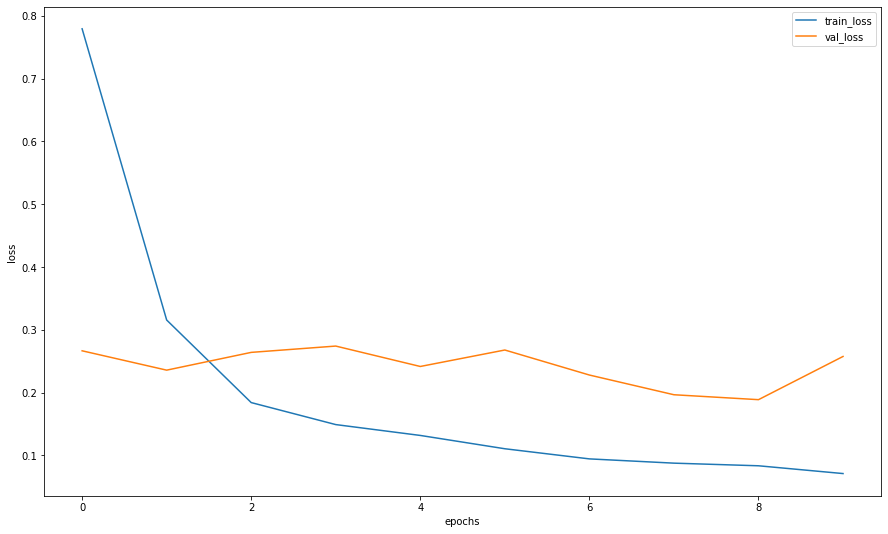

In [61]:
plot_loss(loss, val_loss)

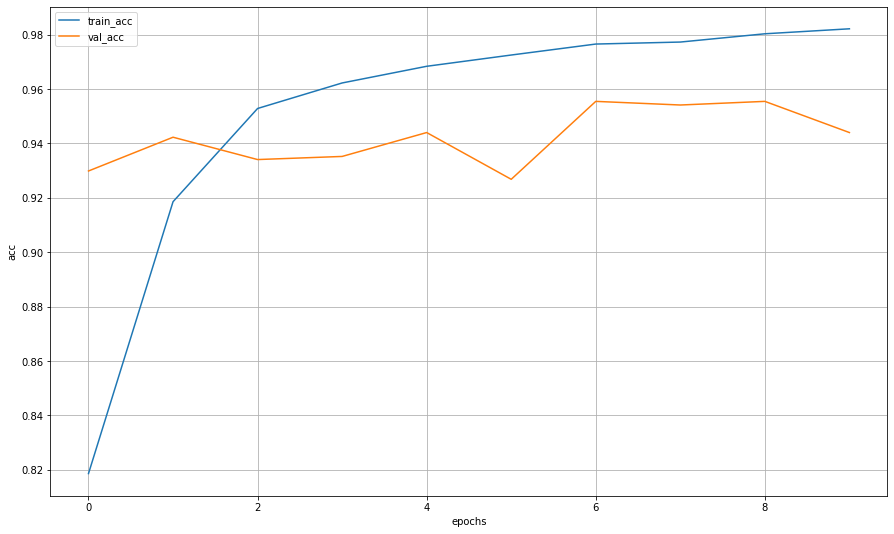

In [62]:
plot_acc(acc, val_acc)

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

In [74]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

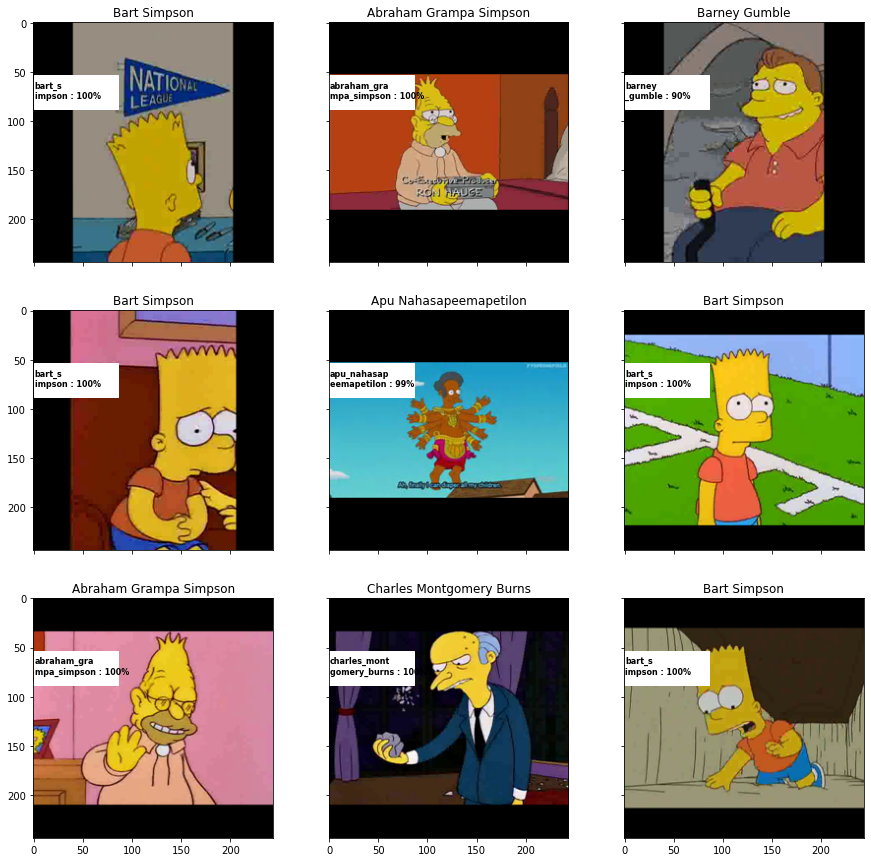

In [77]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(15, 15), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(resnet, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [64]:
resnet.load_state_dict(torch.load('MyBestModel.pth'))
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=16)
probs = predict(resnet, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [65]:
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
df.to_csv('sample_submission1.csv', index=False)

**Stepik Id** -- 461271156

**Team name** -- Roman_Sokolov_461271156

**Kaggle Id** -- 7426411